In [33]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('../data/aden_golfe_matrix_global.csv',sep=';')
df.head()

,Annee (0),quinzaine_week,count
0,2008,3,2
1,2008,6,3
2,2008,7,3
3,2008,8,3
4,2008,10,6


In [37]:
def month(quinzine):
    if(str(quinzine).split('.', 1 )[1]=='5'):
        if len(str(int(str(quinzine).split('.', 1 )[0])+1))==1:
            return '0'+str(int(str(quinzine).split('.', 1 )[0])+1)
        else:
            return str(int(str(quinzine).split('.', 1 )[0])+1)
    else:
        if len(str(quinzine).split('.', 1 )[0])==1:
            return '0'+str(quinzine).split('.', 1 )[0]
        else:
            return str(quinzine).split('.', 1 )[0]
        
def day(quinzine):
    if(quinzine%2==0):
        return '15'
    else:
        return '01'
    
df['month'] =df.apply(lambda row: month(row['quinzaine_week']/2), axis=1)
df['day'] =df.apply(lambda row: day(row['quinzaine_week']), axis=1)
df['date'] =df.apply(lambda row: str(row['Annee (0)'])+'-'+str(row['month'])+'-'+str(row['day']), axis=1)

df['date']=df.apply(lambda row: datetime.datetime.strptime(row['date'], "%Y-%m-%d"), axis=1)

#df['date']=datetime.datetime.strptime(df['date'], "%Y-%m-%d")

print df.head()

   Annee (0)  quinzaine_week  count month day       date
0       2008               3      2    02  01 2008-02-01
1       2008               6      3    03  15 2008-03-15
2       2008               7      3    04  01 2008-04-01
3       2008               8      3    04  15 2008-04-15
4       2008              10      6    05  15 2008-05-15


# Time series prediction

date
2008-02-01    2
2008-03-15    3
2008-04-01    3
2008-04-15    3
2008-05-15    6
2008-06-01    1
2008-06-15    1
2008-07-01    1
2008-07-15    3
2008-08-01    2
Name: count, dtype: int64


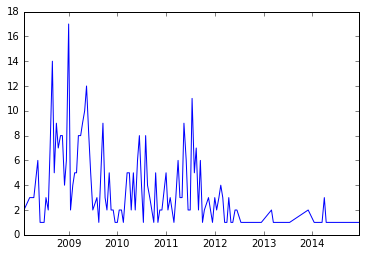

In [38]:
df2=df.set_index('date')
ts = df2['count']
print ts.head(10)
plt.plot(ts)

In [39]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

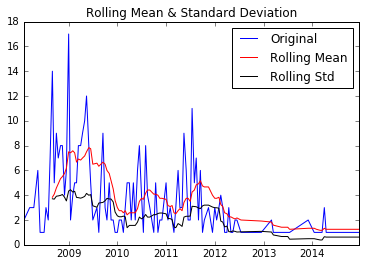

Results of Dickey-Fuller Test:
Test Statistic                  -2.621980
p-value                          0.088539
#Lags Used                       3.000000
Number of Observations Used    110.000000
Critical Value (5%)             -2.888195
Critical Value (1%)             -3.491245
Critical Value (10%)            -2.580988
dtype: float64


In [40]:
test_stationarity(ts)

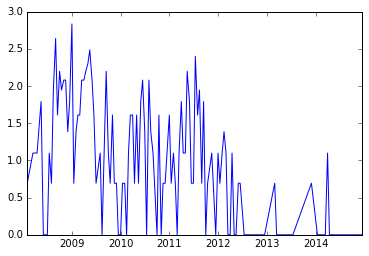

In [41]:
ts_log = np.log(ts)
plt.plot(ts_log)

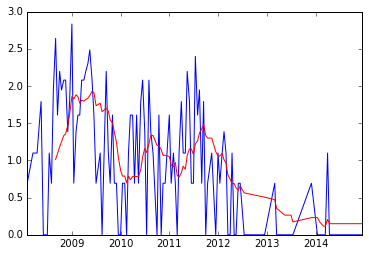

In [42]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index

# Pre process ML

In [4]:
features=['2_week','Years','month','day']
target='count'

In [5]:
dfTrain=df[df['Years']!=2014]
dfTest=df[df['Years']==2014]
print len(dfTrain[dfTrain['count']!=0])
print len(dfTest[dfTest['count']!=0])

print len(dfTrain)
print len(dfTest)

106
8
144
24


# Regression

In [7]:
features_regression=['full_years']

target='count'
dfTrain=df[df['full_years']<2014]
dfTest=df[df['full_years']>2014]



#     zzzz

200


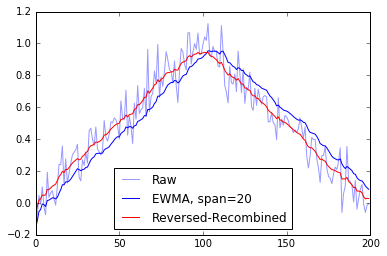

In [8]:
import pandas, numpy as np
ewma = pandas.stats.moments.ewma

# make a hat function, and add noise
x = np.linspace(0,1,100)
x = np.hstack((x,x[::-1]))
x += np.random.normal( loc=0, scale=0.1, size=200 )

print len(x)

plt.plot( x, alpha=0.4, label='Raw' )

# take EWMA in both directions with a smaller span term
fwd = ewma( x, span=15 )          # take EWMA in fwd direction
bwd = ewma( x[::-1], span=15 )    # take EWMA in bwd direction
c = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
c = np.mean( c, axis=0 )          # average  

# regular EWMA, with bias against trend
plt.plot( ewma( x, span=20 ), 'b', label='EWMA, span=20' )

# "corrected" (?) EWMA
plt.plot( c, 'r', label='Reversed-Recombined' )

plt.legend(loc=8)
#plt.savefig( 'ewma_correction.png', fmt='png', dpi=100 )

In [13]:
from sklearn.svm import SVR
import random
import numpy as np

clf  = SVR()
clf.fit(dfTrain[features_regression].values, dfTrain[target].as_matrix())
predic=clf.predict(df[features_regression].values)

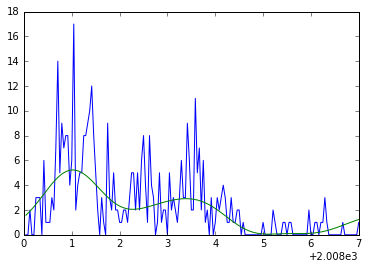

In [11]:
plt.plot(df[features_regression], df[target], label="ground truth")
plt.plot(df[features_regression], predic, label="ground truth")